In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### Load data

In [3]:
#load data
data = pd.read_csv('data/counts_tables/dpl_tpm_counts_kallisto.csv')
data.rename(columns={data.columns[0]: "sample-id" }, inplace = True)
data.set_index("sample-id", inplace = True)
metadata = pd.read_csv('data/mtstp_analysis_metadata.tsv', sep="\t")

#### Functions for parsing data

In [4]:
#get pairwise comparisons
def get_pairwise_comparisons(data):
    comparisons = []
    for sample1 in list(data.index):
        for sample2 in list(data.index):
            if sample1 != sample2:
                if [sample1, sample2] not in comparisons and [sample2, sample1] not in comparisons:
                    comparison = [sample1, sample2]
                    comparisons.append(comparison)
    return comparisons

#function to get pairwise rmse results
def pairwise_rmse(data, comparisons):
    
    rmse_results = pd.DataFrame(columns=["comparison1", "comparison2", "rmse"])
    
    #get gene ids
    gene_ids = list(data.columns)
    #iterate through comparisons
    for comparison in comparisons:
        sample1_data = data.loc[comparison[0]]
        sample2_data = data.loc[comparison[1]]
        
        #get data and calculate total error
        total_se = 0
        for gene in gene_ids:
            sample1_value = sample1_data[gene]
            sample2_value = sample2_data[gene]
            
            exp_error = sample1_value - sample2_value
            exp_error = exp_error ** 2
            
            total_se += exp_error
            
        #calculate rsme
        mse = total_se / len(gene_ids)
        rmse = math.sqrt(mse)
        
        #assemble results
        results_df = pd.DataFrame({'comparison1' : [comparison[0]], 'comparison2' : [comparison[1]], 'rmse' : [rmse]})
        
        rmse_results = pd.concat([rmse_results, results_df])
    
    return rmse_results

#function to run comparisons for a given developmental stage
def rmse(data, metadata, developmental_stage):
    #get stage data
    dev_metadata = metadata.loc[metadata["developmental-stage"] == developmental_stage]
    dev_ids = list(dev_metadata.loc[:, 'sample-id'])
    dev_data = data.loc[dev_ids]
    
    #get comparisons list
    comparisons = get_pairwise_comparisons(dev_data)
    rmse_results = pairwise_rmse(dev_data, comparisons)
    
    #add comparisons of relevance
    plant_comparison = []
    infection_comparison = []
    developmental_stage_comparison = []

    comparison1_values = list(rmse_results["comparison1"])
    comparison2_values = list(rmse_results["comparison2"])

    for i in range(len(comparison1_values)):
        sample1_id = comparison1_values[i]
        sample2_id = comparison2_values[i]

        #curassavica comparisons
        if "ci" in sample1_id and "ci" in sample2_id:
            plant_comparison.append("curassavica:curassavica")
            infection_comparison.append("infected:infected")
        elif "ci" in sample1_id and "cu" in sample2_id:
            plant_comparison.append("curassavica:curassavica")
            infection_comparison.append("infected:uninfected")
        elif "cu" in sample1_id and "cu" in sample2_id:
            plant_comparison.append("curassavica:curassavica")
            infection_comparison.append("uninfected:uninfected")

        #incarnata comparisons
        elif "ii" in sample1_id and "ii" in sample2_id:
            plant_comparison.append("incarnata:incarnata")
            infection_comparison.append("infected:infected")
        elif "ii" in sample1_id and "iu" in sample2_id:
            plant_comparison.append("incarnata:incarnata")
            infection_comparison.append("infected:uninfected")
        elif "iu" in sample1_id and "iu" in sample2_id:
            plant_comparison.append("incarnata:incarnata")
            infection_comparison.append("uninfected:uninfected") 

        #if not a designated comparison, add "NA"
        else:
            plant_comparison.append("NA")
            infection_comparison.append("NA")
            
        #add developmental stage
        developmental_stage_comparison.append(developmental_stage)

    #add columns to dataframe
    rmse_results["infection_comparison"] = infection_comparison
    rmse_results["plant_comparison"] = plant_comparison
    rmse_results["developmental_stage"] = developmental_stage_comparison

    #select only columns of relevant comparisons
    rmse_comparison_data = rmse_results.loc[(rmse_results["infection_comparison"] != "NA") & (rmse_results["plant_comparison"] != "NA")]
    
    return rmse_comparison_data

#### Get RMSE data

In [5]:
thrid_instar_rmse_results = rmse(data, metadata, "third-instar")
print("Completed third instar RMSE comparisons")
fifth_instar_rmse_results = rmse(data, metadata, "fifth-instar")
print("Completed fifth instar RMSE comparisons")
early_pupa_rmse_results = rmse(data, metadata, "early-pupa")
print("Completed early pupa RMSE comparisons")
late_pupa_rmse_results = rmse(data, metadata, "late-pupa")
print("Completed late pupa RMSE comparisons")
adult_rmse_results = rmse(data, metadata, "adult")
print("Completed adult RMSE comparisons")

Completed third instar RMSE comparisons
Completed fifth instar RMSE comparisons
Completed early pupa RMSE comparisons
Completed late pupa RMSE comparisons
Completed adult RMSE comparisons


#### Make boxplots for initial inspection of data

<AxesSubplot:xlabel='plant_comparison', ylabel='rmse'>

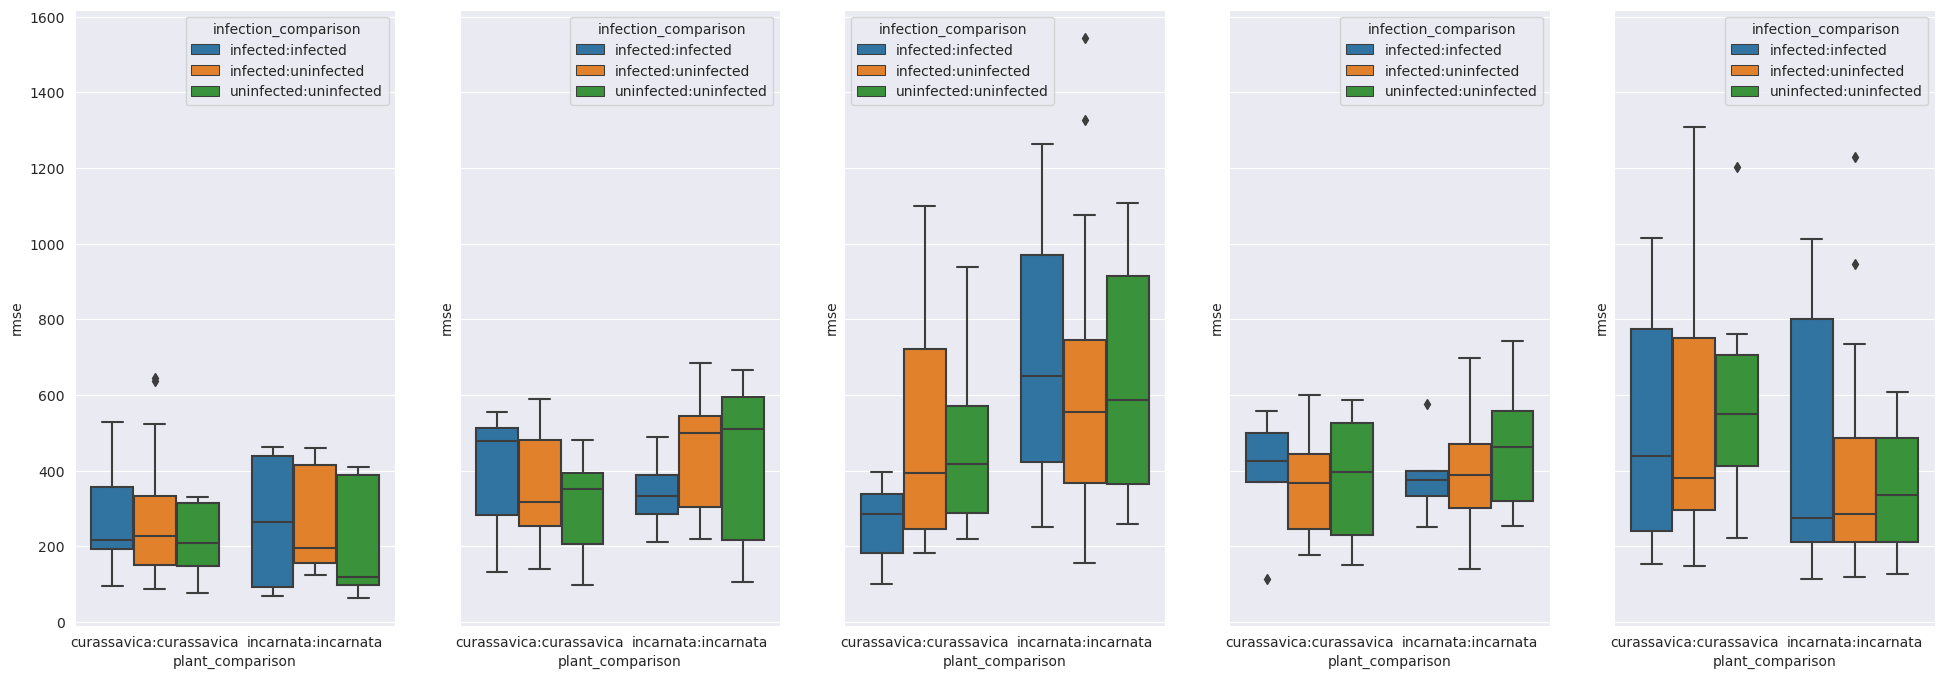

In [7]:
#make boxplot of comparisons
sns.set_style('darkgrid')
sns.set_palette("tab10")

fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(1, 5, figsize=(24, 8), sharey=True)
#third instar boxplot
sns.boxplot(data=thrid_instar_rmse_results, y="rmse", x="plant_comparison", hue="infection_comparison", ax=ax1)
#fifth instar boxplot
sns.boxplot(data=fifth_instar_rmse_results, y="rmse", x="plant_comparison", hue="infection_comparison", ax=ax2)
#early pupa boxplot
sns.boxplot(data=early_pupa_rmse_results, y="rmse", x="plant_comparison", hue="infection_comparison", ax=ax3)
#late pupa boxplot
sns.boxplot(data=late_pupa_rmse_results, y="rmse", x="plant_comparison", hue="infection_comparison", ax=ax4)
#adult boxplot
sns.boxplot(data=adult_rmse_results, y="rmse", x="plant_comparison", hue="infection_comparison", ax=ax5)

#### Compare infected vs uninfected for each plant

<AxesSubplot:xlabel='developmental_stage', ylabel='rmse'>

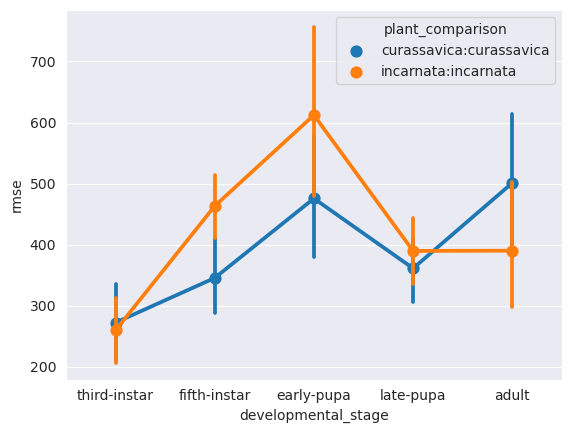

In [8]:
#concatenate dataframes
total_rmse_results = pd.concat([thrid_instar_rmse_results, fifth_instar_rmse_results, early_pupa_rmse_results, late_pupa_rmse_results, adult_rmse_results])
#select only infected v. uninfected data
infected_vs_uninfeected_total_rmse_results = total_rmse_results.loc[total_rmse_results["infection_comparison"] == "infected:uninfected"]

#make point plot
sns.pointplot(data=infected_vs_uninfeected_total_rmse_results, y="rmse", x="developmental_stage", hue="plant_comparison")
